# skeletonization + resize + sending pixels to csv


In [4]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
import csv
from skimage import img_as_float
from skimage import io, color, morphology

In [10]:
# point to license plate image (works well with custom crop function)
img = cv2.imread("20.jpg", 0)
cv2.imshow("input", img)
cv2.waitKey(0)

gray = cv2.resize(img, None, fx = 1, fy = 1, interpolation = cv2.INTER_CUBIC)
blur = cv2.GaussianBlur(img, (5,5), 0)
gray = cv2.medianBlur(img, 3)
# perform otsu thresh (using binary inverse since opencv contours work better with white text)
ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
cv2.imshow("Thresh image", thresh)
cv2.waitKey(0)


-1

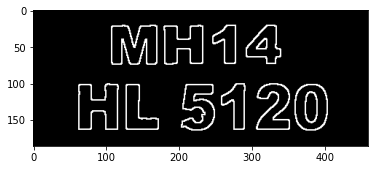

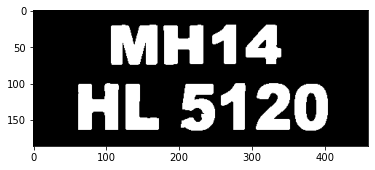

In [11]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
gradient=cv2.morphologyEx(thresh,cv2.MORPH_GRADIENT,kernel)
plt.imshow(gradient,cmap='gray')
plt.show()
# apply dilation 
dilation = cv2.dilate(thresh, kernel, iterations = 1)
plt.imshow(dilation,cmap='gray')
#cv2.imshow("dilation", dilation)
plt.show()
# find contours

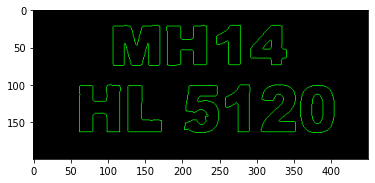

In [16]:
# find contours
try:
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
except:
    ret_img, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

#drawing these contours
blank = np.zeros((200, 450, 3), dtype='uint8')
cv2.drawContours(blank, contours ,-1, (0,255,0), 1)

plt.imshow(blank,cmap='gray')
plt.show()
#cv2.imshow("contours drawn", blank)
#cv2.waitKey(0)
#cv2.destroyAllWindows()'''

# region interest and its skeleton

roi_size: (35, 35)


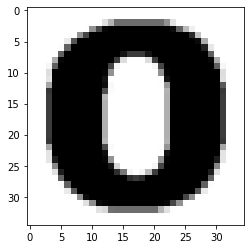

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x216C64C7130>
skel_size: (35, 35)


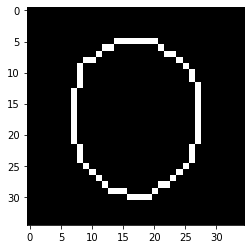

roi_size: (35, 35)


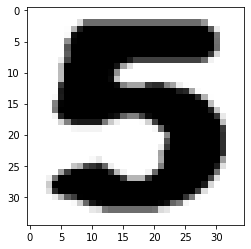

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x216C6CEBB50>
skel_size: (35, 35)


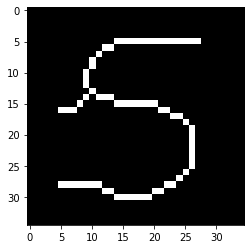

roi_size: (35, 35)


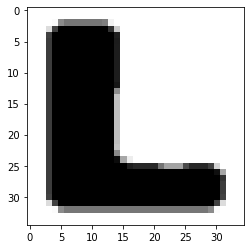

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x216C6CEBB50>
skel_size: (35, 35)


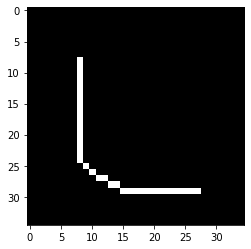

roi_size: (35, 35)


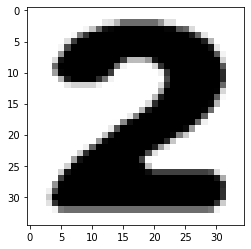

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x216C6CEBB50>
skel_size: (35, 35)


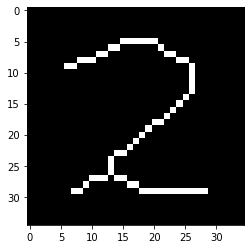

roi_size: (35, 35)


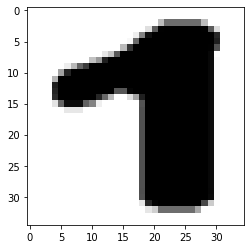

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x216C6CEBB50>
skel_size: (35, 35)


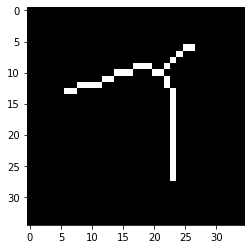

roi_size: (35, 35)


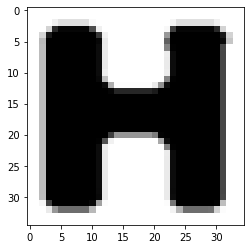

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x216C6CEBB50>
skel_size: (35, 35)


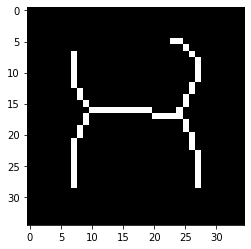

roi_size: (35, 35)


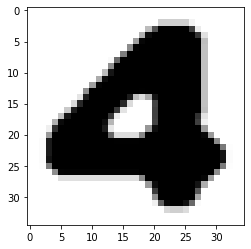

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x216C6CEBB50>
skel_size: (35, 35)


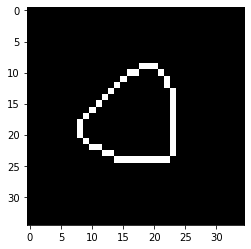

roi_size: (35, 35)


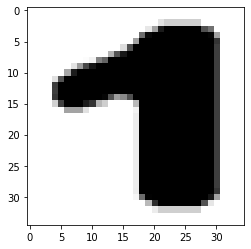

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x216C6D2A160>
skel_size: (35, 35)


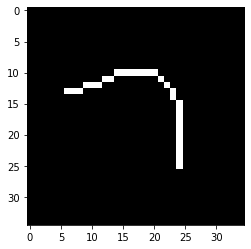

roi_size: (35, 35)


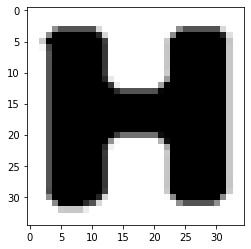

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x216C6D2A160>
skel_size: (35, 35)


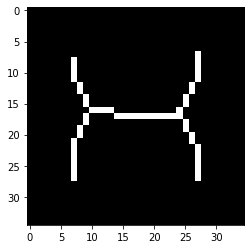

roi_size: (35, 35)


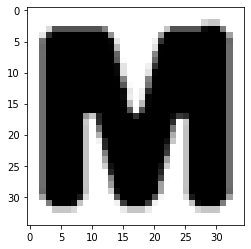

<class 'numpy.ndarray'>
<PIL.Image.Image image mode=1 size=35x35 at 0x216C6D2A160>
skel_size: (35, 35)


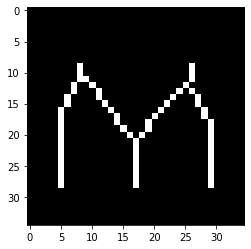

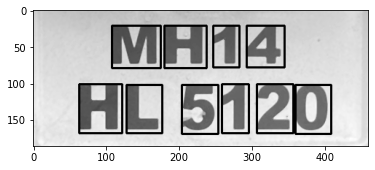

In [17]:
# create copy of image
from numpy import asarray
import sys
from skimage.exposure import histogram
from PIL import Image
im2 = gray.copy()

plate_num = ""
ROI_number = 0
# loop through contours and find letters in license plate
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for cnt in cnts:
    x,y,w,h = cv2.boundingRect(cnt)
    height, width = im2.shape
    
    # if height of box is not a quarter of total height then skip
    #if height / float(h) > 12: continue
    if height / float(h) > 122: continue
    ratio = h / float(w)
    # if height to width ratio is less than 1.5 skip
    if ratio < 0.5: continue
    area = h * w
    # if width is not more than 25 pixels skip
    #if width / float(w) > 15: continue
    if width / float(w) > 125: continue
    # if area is less than 100 pixels skip
    if area < 800: continue
    # draw the rectangle
   # im2 = im2.resize((35,35))
    rect = cv2.rectangle(im2, (x,y), (x+w+5, y+h+5), (0,255,0),2)
    roi = thresh[y-5:y+h+5, x-5:x+w+5]
    #roi = thresh[y:y, x:x]
    roi = cv2.bitwise_not(roi)
    roi = cv2.medianBlur(roi,7)
    roi = Image.fromarray(roi)
    roi=roi.resize((35,35),resample=3, box=None, reducing_gap=None)
   #roi.resize((50,50))
    print("roi_size:",roi.size)
    ROI_number = ROI_number + 1
    plt.imsave('extracted/skel_{}.png'.format(ROI_number), roi, cmap='gray')
    plt.imshow(roi, cmap='gray')
    plt.show()
    
    #applying skeletonize 
    image = img_as_float(roi)
    image_binary = image < 0.5
    out_skeletonize = morphology.skeletonize(image_binary)
    out_thin = morphology.thin(image_binary)
    print(type(out_thin))
    #rows , cols = roi.shape
    #roi = roi[0:rows , 0:cols]
    #roi = roi.resize((35,35)) 
    #out_thin.resize((50,50), resample=image.NEAREST)

    #array to image
    im = Image.fromarray(out_thin)
    im=im.resize((35,35),resample=5, box=None, reducing_gap=None)
    print(im)
    print("skel_size:",im.size)
    plt.imshow(im, cmap='gray')
    plt.show()
    plt.imsave('extracted/skel_{}.jpeg'.format(ROI_number), im, cmap='gray')
    #cv2.imwrite('extracted/skel_{}.png'.format(ROI_number),roi)
    
    #cv2.imwrite('tr_20X20/ROI_{}.png'.format(ROI_number),roi)
   # ROI_number = ROI_number + 1
#print("features")
plt.imshow(im2, cmap='gray')
plt.show()

# Normalization + sending pixels to csv

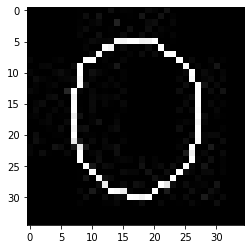

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(35, 35)
[[0.         0.         0.         ... 0.         0.00392157 0.00392157]
 [0.00392157 0.         0.         ... 0.07058824 0.07058824 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.00392157 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.02352941 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[0. 0. 0. ... 0. 0. 0.]


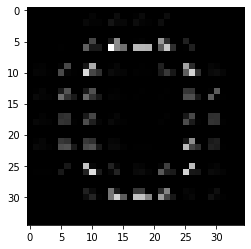

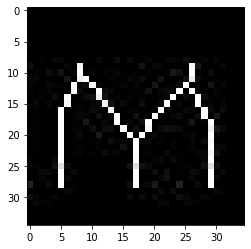

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(35, 35)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.09411765 0.09411765 0.0627451  ... 0.         0.         0.        ]
 [0.01568628 0.01568628 0.01568628 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[0. 0. 0. ... 0. 0. 0.]


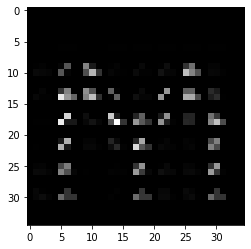

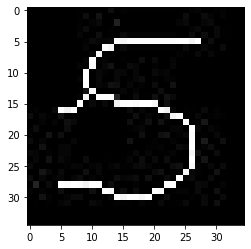

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(35, 35)
[[0.         0.         0.         ... 0.         0.00392157 0.00392157]
 [0.00392157 0.         0.         ... 0.00392157 0.00392157 0.00392157]
 [0.00392157 0.00392157 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.03529412 0.03529412]
 [0.03529412 0.         0.         ... 0.01568628 0.01568628 0.01176471]]
[0.         0.         0.         ... 0.01568628 0.01568628 0.01176471]


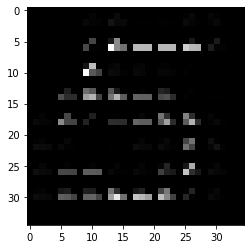

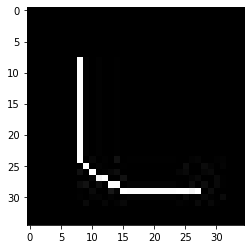

Data Type: float32
Min: 0.000, Max: 254.000
Min: 0.000, Max: 1.000
(35, 35)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.00787402 0.00787402]
 [0.00787402 0.         0.         ... 0.         0.         0.        ]]
[0. 0. 0. ... 0. 0. 0.]


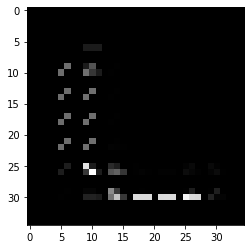

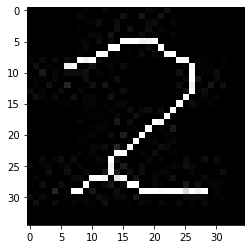

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(35, 35)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.03137255 0.03137255 ... 0.07058824 0.07058824 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.05882353 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[0. 0. 0. ... 0. 0. 0.]


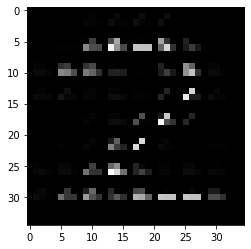

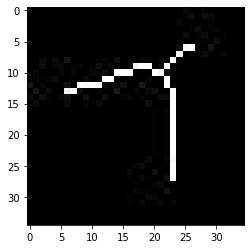

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(35, 35)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.99607843 0.99607843 ... 1.         1.         0.        ]]
[0. 0. 0. ... 1. 1. 0.]


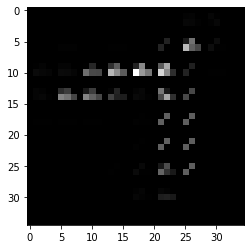

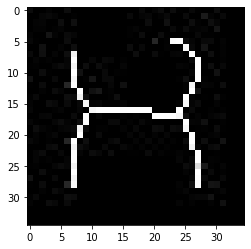

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(35, 35)
[[0.04313726 0.04313726 0.04313726 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.04705882]
 [0.04705882 0.04705882 0.00392157 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.06666667 0.06666667 0.06666667 ... 0.08235294 0.         0.        ]
 [0.         0.03529412 0.03529412 ... 0.         0.         0.        ]]
[0.04313726 0.04313726 0.04313726 ... 0.         0.         0.        ]


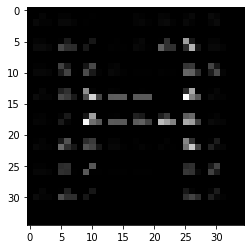

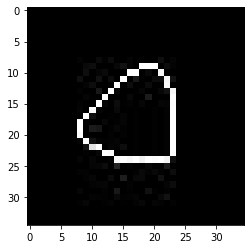

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(35, 35)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.06666667 0.06666667]
 [0.06666667 0.         0.         ... 0.9607843  0.9607843  0.07450981]]
[0.         0.         0.         ... 0.9607843  0.9607843  0.07450981]


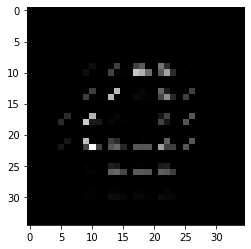

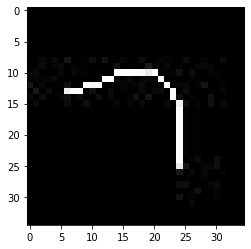

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(35, 35)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01568628 0.01568628 0.05882353 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.02745098 0.02745098]
 [0.02745098 1.         1.         ... 0.         0.         0.        ]]
[0. 0. 0. ... 0. 0. 0.]


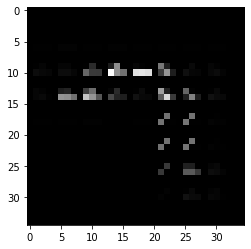

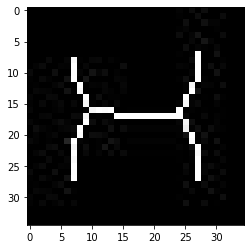

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(35, 35)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.01568628 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00784314 0.00784314 0.00784314 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[0. 0. 0. ... 0. 0. 0.]


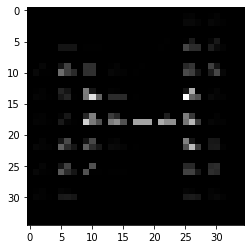

In [32]:
import glob
pl_img = []
for img in glob.glob("extracted/*.jpeg"):
    n= cv2.imread(img)
    pl_img.append(n)
    im2arr = np.array(n)
    plt.imshow(n, cmap='gray')
    plt.show()
    #print(im2arr)
    
#normalization start
    min = sys.maxsize
    max = -sys.maxsize
    image = n.copy()
    image.resize((35,35))
    np_image = asarray(image)
    if min > np_image.min():
        min = np_image.min()
    if max < np_image.max():
        max = np_image.max()    
        
    np_image = np_image.astype('float32')
    #print("BEGINNING PIXEL VALUES", np_image)
    print('Data Type: %s' % np_image.dtype)
    print('Min: %.3f, Max: %.3f' % (np_image.min(), np_image.max()))
    np_image -= min
    np_image /= (max - min)
    print('Min: %.3f, Max: %.3f' % (np_image.min(), np_image.max()))
    #np.set_printoptions(threshold=np.inf)
    #print(np_image)
    print(np_image.shape)
    print(np_image)
    '''Normalization end'''
    #sending pixels to csv
    value = np.asarray(np_image, dtype=None)
    value = value.flatten()
    print(value)
    with open("csv/img_pixels.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)
    #feature ex 
    fd, hog_image = hog(n, orientations=5, pixels_per_cell=(4,4),cells_per_block=(5,5), visualize=True, multichannel=True)
    #plt.axis("off")
    plt.imshow(hog_image, cmap="gray")
    plt.show()
    

# feature extraction 

In [21]:
from skimage.feature import hog

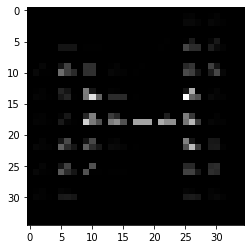

In [30]:
fd, hog_image = hog(n, orientations=5, pixels_per_cell=(4,4),cells_per_block=(5,5), visualize=True, multichannel=True)
    #plt.axis("off")
plt.imshow(hog_image, cmap="gray")
plt.show()

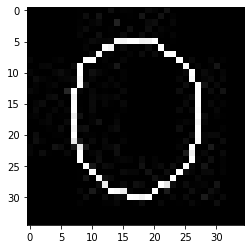

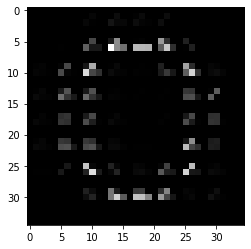

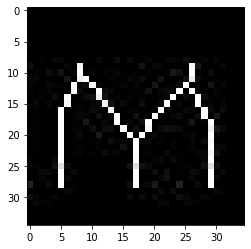

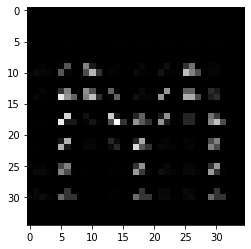

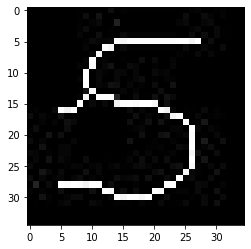

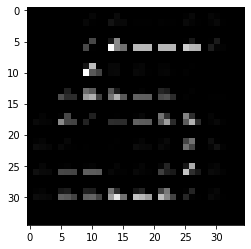

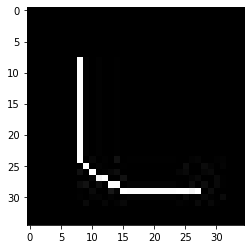

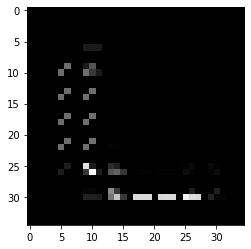

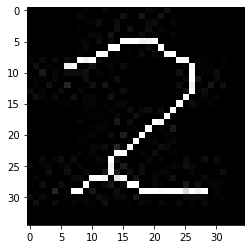

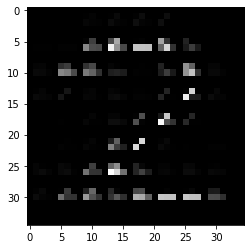

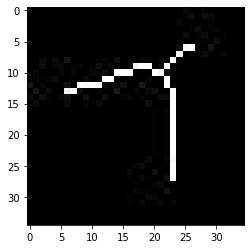

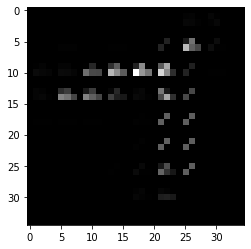

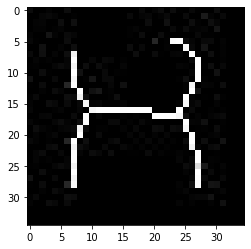

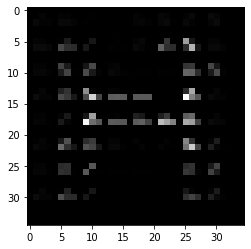

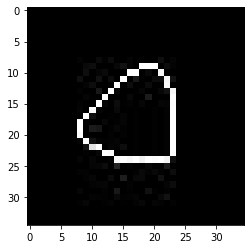

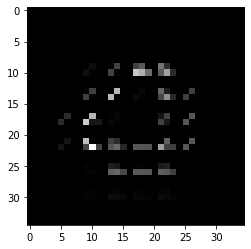

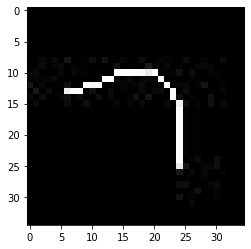

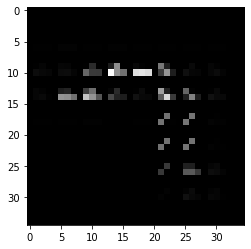

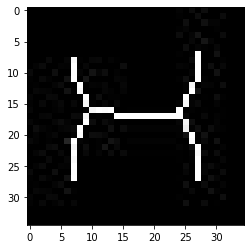

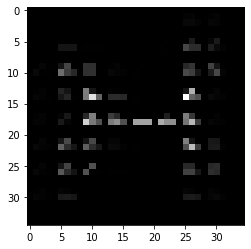

In [39]:
#fe ex with hog
from skimage.feature import hog
import glob
pl_img = []
for img in glob.glob("extracted/*.jpeg"):
    n= cv2.imread(img)
    pl_img.append(n)
    im2arr = np.array(n)
    plt.imshow(n, cmap='gray')
    plt.show()
    
    fd, hog_image = hog(n, orientations=9, pixels_per_cell=(4,4),cells_per_block=(2,2), visualize=True, multichannel=True)
    #plt.axis("off")
    plt.imshow(hog_image, cmap="gray")
    plt.show()

# Normalization

In [10]:
#normalization
min = sys.maxsize
max = -sys.maxsize
image = roi.copy()
   #image.resize((35,35))
np_image = asarray(image)
if min > np_image.min():
      min = np_image.min()
if max < np_image.max():
      max = np_image.max()    
        
np_image = np_image.astype('float32')
   #print("BEGINNING PIXEL VALUES", np_image)
print('Data Type: %s' % np_image.dtype)
print('Min: %.3f, Max: %.3f' % (np_image.min(), np_image.max()))
np_image -= min
np_image /= (max - min)
print('Min: %.3f, Max: %.3f' % (np_image.min(), np_image.max()))
    #np.set_printoptions(threshold=np.inf)
    #print(np_image)
print(np_image.shape)
print(np_image)
    
    #normalization end

Data Type: float32
Min: 0.000, Max: 255.000
Min: 0.000, Max: 1.000
(35, 35)
[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         0.85882354 ... 1.         1.         1.        ]
 [1.         1.         0.2784314  ... 1.         1.         1.        ]
 ...
 [1.         0.8509804  0.         ... 1.         1.         1.        ]
 [1.         0.9647059  0.5058824  ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


# sending pixels to csv


In [11]:
value = np.asarray(np_image, dtype=None)
value = value.flatten()
print(value)
with open("csv/img_pixels.csv", 'a') as f:
    writer = csv.writer(f)
    writer.writerow(value)

[1. 1. 1. ... 1. 1. 1.]


In [12]:
     '''# Save Greyscale values
    value = np.asarray(np_image, dtype=np.float32).reshape((np_image.size[1], np_image.size[0]))
    value = value.flatten()
    print(value)
    with open("csv/img_pixels.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)'''

'# Save Greyscale values\n    value = np.asarray(np_image, dtype=np.float32).reshape((np_image.size[1], np_image.size[0]))\n    value = value.flatten()\n    print(value)\n    with open("csv/img_pixels.csv", \'a\') as f:\n   writer = csv.writer(f)\n   writer.writerow(value)'

In [16]:
#sending pixels to csv'''
    lst=[]
    lst=roi.tolist()
    lst

    a = np.array(lst)
    a

    value = np.asarray(a, dtype='int')
    value = value.flatten()
    print(value)
    with open("csv/img_pixels.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)

IndentationError: unexpected indent (<ipython-input-16-d8c0f22176a3>, line 2)

# random codes

TypeError: Image data of dtype object cannot be converted to float

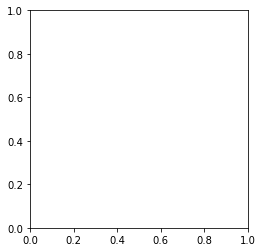

In [15]:
#img = cv.imread(path)
img = out_thin.resize((50,50), refcheck=False)
normalizedImg = np.zeros((200, 200))
normalizedImg = cv2.normalize(img,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
#print(normalizedImg.shape)

plt.imshow(normalizedImg, cmap='gray')
plt.show()
#cv2.imshow('dst_rt', normalizedImg)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [21]:
import os
import os.path
rn =0
f = 'C://Users/shubh/OneDrive/Desktop/dumpy/extracted'
for file in os.listdir(f):
    f_img = f+"/"+file
    img = cv2.imread(f_img)
    cv2.resize(img, (20,20) ,fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
    rn = rn +1
    cv2.imwrite('img_20X20/img2020_{}.png'.format(rn),f_img) 

error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


In [77]:
print(out_thin)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


In [13]:
print(np_image.astype)

<built-in method astype of numpy.ndarray object at 0x000002BE18839150>


In [24]:
import csv
lst=[]
lst=np_image.tolist()
lst

a = np.array(lst)
a

value = np.asarray(a)
value = value.flatten()
print(value)
with open("csv/img_pixels.csv", 'a') as f:
    writer = csv.writer(f)
    writer.writerow(value)

[1. 1. 1. ... 1. 1. 1.]


In [ ]:
# Save Greyscale values
value = np.asarray(img_grey.getdata(), dtype=np.int).reshape((img_grey.size[1], img_grey.size[0]))
value = value.flatten()
print(value)
    with open("img_pixels.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(value)

In [ ]:
image = cv2.imread("13.jpg")
plt.imshow(image)
plt.show()
#thinned = cv2.ximgproc.thinning(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY))

In [ ]:

    #  hat tip to http://felix.abecassis.me/2011/09/opencv-morphological-skeleton/

img = img.copy() # don't clobber original
skel = img.copy()

skel[:,:] = 0
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))

while True:
        eroded = cv2.morphologyEx(img, cv2.MORPH_ERODE, kernel)
        temp = cv2.morphologyEx(eroded, cv2.MORPH_DILATE, kernel)
        temp  = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img[:,:] = eroded[:,:]

        plt.imshow(skel,cmap='gray')
        plt.show()

In [37]:
import scipy.ndimage.morphology as m
import numpy as np
import cv2

def skeletonize(img):
    h1 = np.array([[0, 0, 0],[0, 1, 0],[1, 1, 1]]) 
    m1 = np.array([[1, 1, 1],[0, 0, 0],[0, 0, 0]]) 
    h2 = np.array([[0, 0, 0],[1, 1, 0],[0, 1, 0]]) 
    m2 = np.array([[0, 1, 1],[0, 0, 1],[0, 0, 0]])    
    hit_list = [] 
    miss_list = []
    for k in range(4): 
        hit_list.append(np.rot90(h1, k))
        hit_list.append(np.rot90(h2, k))
        miss_list.append(np.rot90(m1, k))
        miss_list.append(np.rot90(m2, k))    
    img = img.copy()
    while True:
        last = img
        for hit, miss in zip(hit_list, miss_list): 
            hm = m.binary_hit_or_miss(img, hit, miss) 
            img = np.logical_and(img, np.logical_not(hm)) 
        if np.all(img == last):  
            break
    return img

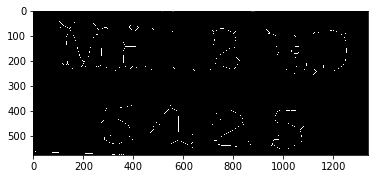

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False  True ... False False False]
 [False  True False ... False False False]
 [ True False False ... False False False]]
<class 'numpy.ndarray'>


In [50]:
img = cv2.imread("13.jpg",0)
ret,img = cv2.threshold(img,127,255,0)
element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
img = 255 - img
img = cv2.dilate(img, element, iterations=3)

skel = skeletonize(img)
plt.imshow(skel, cmap="gray", interpolation="nearest")
plt.show()
print(skel)
print(type(skel))